<a href="https://colab.research.google.com/github/DimitriLeandro/DA2Group10/blob/main/pretrained_satellighte_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading datasets and importing libs

In [ ]:
!pip install satellighte

In [1]:
import imageio
import satellighte as sat
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch
import torchmetrics as tm
import pytorch_lightning as pl
from pathlib import Path
from PIL import Image
from torch import flatten
from torchvision import transforms as tt
from torchvision.transforms.transforms import Resize
from torch.utils.data import DataLoader, random_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
!wget -q https://uni-muenster.sciebo.de/s/KNjoOrXdWecbvdh/download?path=%2F&files=training_patches.zip
!unzip -qq /content/download?path=%2F
!unzip -qq /content/task_2/training_patches.zip
!unzip -qq /content/task_2/unlabeled_training_data.zip
!unzip -qq /content/task_2/validation_data.zip

## Mounting drive to save model checkpoints

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Loading pretrained model

In [ ]:
sat.available_models()

['efficientnet_b0_eurosat', 'mobilenetv2_default_eurosat']

In [55]:
del model, train_tt, val_tt, hparams, train_ds, val_ds, train_dl, val_dl, trainer, checkpoint_callback

In [3]:
model_name = 'mobilenetv2_default_eurosat'
model = sat.Classifier.from_pretrained(
    model_name, 
    sat.get_model_latest_version(model_name)
)
model.zero_grad()

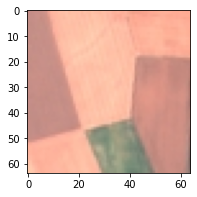

AnnualCrop.jpg
[{'AnnualCrop': 0.99, 'Forest': 0.0, 'HerbaceousVegetation': 0.0, 'Highway': 0.0, 'Industrial': 0.0, 'Pasture': 0.0, 'PermanentCrop': 0.0, 'Residential': 0.0, 'River': 0.0, 'SeaLake': 0.0}] 




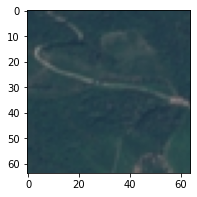

Forest.jpg
[{'Forest': 0.37, 'HerbaceousVegetation': 0.27, 'Pasture': 0.18, 'River': 0.07, 'Highway': 0.04, 'PermanentCrop': 0.03, 'SeaLake': 0.02, 'Residential': 0.01, 'AnnualCrop': 0.0, 'Industrial': 0.0}] 




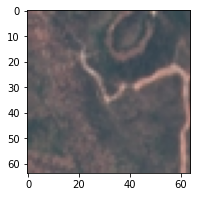

HerbaceousVegetation.jpg
[{'HerbaceousVegetation': 0.74, 'PermanentCrop': 0.18, 'Highway': 0.06, 'AnnualCrop': 0.01, 'River': 0.01, 'Forest': 0.0, 'Industrial': 0.0, 'Pasture': 0.0, 'Residential': 0.0, 'SeaLake': 0.0}] 




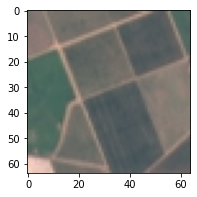

PermanentCrop.jpg
[{'PermanentCrop': 0.48, 'AnnualCrop': 0.47, 'Highway': 0.03, 'HerbaceousVegetation': 0.01, 'Forest': 0.0, 'Industrial': 0.0, 'Pasture': 0.0, 'Residential': 0.0, 'River': 0.0, 'SeaLake': 0.0}] 




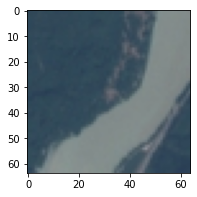

River.jpg
[{'River': 0.88, 'AnnualCrop': 0.08, 'Highway': 0.01, 'SeaLake': 0.01, 'Forest': 0.0, 'HerbaceousVegetation': 0.0, 'Industrial': 0.0, 'Pasture': 0.0, 'PermanentCrop': 0.0, 'Residential': 0.0}] 




In [62]:
img_urls = [
    'https://raw.githubusercontent.com/canturan10/satellighte/master/src/eurosat_samples/AnnualCrop.jpg',
    'https://raw.githubusercontent.com/canturan10/satellighte/master/src/eurosat_samples/Forest.jpg',
    'https://raw.githubusercontent.com/canturan10/satellighte/master/src/eurosat_samples/HerbaceousVegetation.jpg',
    'https://raw.githubusercontent.com/canturan10/satellighte/master/src/eurosat_samples/PermanentCrop.jpg',
    'https://raw.githubusercontent.com/canturan10/satellighte/master/src/eurosat_samples/River.jpg'
]

model.eval()

for img_url in img_urls:
    img = imageio.imread(img_url)
    results = model.predict(img)
    plt.imshow(img)
    plt.show()
    print(img_url.split('/')[-1])
    print(results, '\n\n')

## Image transformers

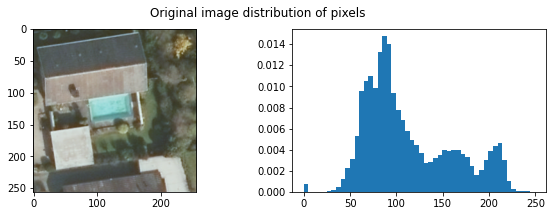

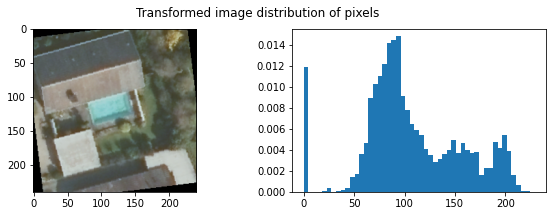

In [4]:
# this method sets model.mean and model.std
model.configure_preprocess()

# input size of images
input_size = (240, 240)

# creating a preprocessing + data augmentation unit for the training data
train_tt = tt.Compose([
    tt.Resize(input_size),
    tt.ColorJitter(brightness=0.15, contrast=0.33, saturation=0.2, hue=0.05),
    tt.RandomRotation(degrees=15),
    tt.RandomHorizontalFlip(p=0.5),
    tt.RandomVerticalFlip(p=0.5),
    # tt.GaussianBlur(kernel_size=(5, 9), sigma=(0.01, 0.1)),
    # tt.RandomPerspective(distortion_scale=0.1, p=0.2),
    # tt.RandomPosterize(bits=2),
])

# creating a preprocessing unit for the validation data
val_tt = tt.Compose([
  tt.Resize(input_size)
])

# loading an image sample
# '../../../mnt/c/Users/dimit/Downloads/training_patches/training_patches/background/1G52LP.png'
img = Image.open('/content/drive/MyDrive/training_patches/pools/4B37MU.png')

# lets have a look at the original image and its pixels values distribution
plt.rcParams['figure.figsize'] = (10,3)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(img)
axs[1].hist(np.asarray(img).ravel(), bins=50, density=True)
plt.suptitle('Original image distribution of pixels')
plt.show()

# using the preprocessing operations to transform the image to a pytorch tensor
img_tt = train_tt(img)
 
# lets have a look at the trasnformed image and its pixels values distribution
fig, axs = plt.subplots(1, 2)
axs[0].imshow(img_tt)
axs[1].hist(np.asarray(img_tt).ravel(), bins=50, density=True)
plt.suptitle('Transformed image distribution of pixels')
plt.show()

## Hyperparameters

In [5]:
hparams = {
    'learning_rate': 1e-5,
    'momentum':      0.9,
    'weight_decay':  3e-4,
    'gamma':         0.5,
    'milestones':    [1, 5, 10, 20, 50, 100],
    'max_epoch':     10,
    'batch_size':    16,
    'criterion':     'cross_entropy',
    'optimizer':     'sgd',
    'device':        torch.cuda.current_device() #torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
}

## Loading dataset

We need to create our own Dataset class that inherit torch.Dataset in order to create a torch.utils.data.DataLoader and fine tune the model. 

To do this, modify this code: https://github.com/canturan10/satellighte/blob/master/satellighte/datasets/eurosat.py

In [6]:
class CustomDataset(sat.datasets.base.BaseDataset):
    
    def __init__(
        self, 
        root_dir, 
        transforms, 
        max_background_imgs = 500,
        max_pools_imgs      = 500,
        max_pounds_imgs     = 500,
        max_solar_imgs      = 500,
        max_trampoline_imgs = 500
    ):
        self.root_dir            = root_dir
        self.transforms          = transforms
        self.max_background_imgs = max_background_imgs
        self.max_pools_imgs      = max_pools_imgs
        self.max_pounds_imgs     = max_pounds_imgs
        self.max_solar_imgs      = max_solar_imgs
        self.max_trampoline_imgs = max_trampoline_imgs
        ids, targets    = self._get_dataset()
        super().__init__(ids, targets, transforms=transforms)

    @property
    def num_classes(self):
        return len(self.__classes)

    @property
    def classes(self):
        return self.__classes

    def name_to_id(self, name: str):
        return self.__classes.index(name)

    def id_to_name(self, idx):
        return self.__classes[idx]

    def _get_dataset(self):
        labels          = []
        filenames       = []
        background_imgs_count = self.max_background_imgs
        pools_imgs_count      = self.max_pools_imgs
        pounds_imgs_count     = self.max_pounds_imgs
        solar_imgs_count      = self.max_solar_imgs
        trampoline_imgs_count = self.max_trampoline_imgs
        
        for class_path in self.root_dir.iterdir():
            if class_path.is_file():
                continue
            for img_path in class_path.iterdir():
                if img_path.suffix != '.png':
                    continue
                filenames.append(img_path)
                labels.append(class_path.name)

                if class_path.name == 'background':
                    background_imgs_count -= 1
                    if background_imgs_count == 0:
                        break
                if class_path.name == 'pools':
                    pools_imgs_count -= 1
                    if pools_imgs_count == 0:
                        break
                if class_path.name == 'pounds':
                    pounds_imgs_count -= 1
                    if pounds_imgs_count == 0:
                        break
                if class_path.name == 'solar':
                    solar_imgs_count -= 1
                    if solar_imgs_count == 0:
                        break
                if class_path.name == 'trampoline':
                    trampoline_imgs_count -= 1
                    if trampoline_imgs_count == 0:
                        break
                
        filenames = np.asarray(filenames)
        labels = np.asarray(labels)

        labels = labels[filenames.argsort()]
        filenames = filenames[filenames.argsort()]

        # convert to integer labels
        label_encoder = LabelEncoder()
        label_encoder.fit(np.sort(np.unique(labels)))
        labels = label_encoder.transform(labels)
        labels = np.asarray(labels)

        # remember label encoding
        self.__classes = list(label_encoder.classes_)
            
        return filenames.tolist(), labels.tolist()

In [7]:
# train dataset
train_ds = CustomDataset(
    # '../../../mnt/c/Users/dimit/Downloads/training_patches/training_patches/'
    root_dir            = Path('/content/drive/MyDrive/training_patches'),
    transforms          = train_tt,
    max_background_imgs = 50,
    max_pools_imgs      = 50,
    max_pounds_imgs     = 50,
    max_solar_imgs      = 50,
    max_trampoline_imgs = 50
)

# val dataset
val_ds = CustomDataset(
    # '../../../mnt/c/Users/dimit/Downloads/unlabeled_training_data/validation_labeled_data_0FRGJD/'
    root_dir   = Path('/content/drive/MyDrive/validation_labeled_data_0FRGJD'),
    transforms = train_tt,
    max_background_imgs = 10,
    max_pools_imgs      = 10,
    max_pounds_imgs     = 10,
    max_solar_imgs      = 10,
    max_trampoline_imgs = 10
)

# creating DataLoader for training
train_dl = DataLoader(
    train_ds,
    batch_size = hparams.get('batch_size'),
    shuffle    = True,
)

# creating DataLoader for valdiation
val_dl = DataLoader(
    val_ds,
    batch_size = hparams.get('batch_size'),
    shuffle    = False,
)

#### Sanity check

In [8]:
print(train_ds.classes)
print(val_ds.classes)
print(len(train_ds.ids))
print(len(val_ds.ids))
print(train_ds.ids[-1:])
print(val_ds.ids[-1:])

['background', 'ponds', 'pools', 'solar', 'trampoline']
['background', 'pools', 'pounds', 'solar', 'trampoline']
166
49
[PosixPath('/content/drive/MyDrive/training_patches/trampoline/ZC3Y7H.png')]
[PosixPath('/content/drive/MyDrive/validation_labeled_data_0FRGJD/trampoline/851.png')]


## Setting training environment

In [9]:
# adding the metric we'd like to measure while the epochs go on
model.add_metric(
    'balanced_accuracy',
    tm.Accuracy(
        num_classes = len(train_ds.classes),
        average     = 'weighted'
    )
)

model.add_metric(
    'average_precision',
    tm.AveragePrecision(
        num_classes = len(train_ds.classes),
        average     = 'weighted'
    ),
)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [10]:
 # define checkpoint callback
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath    = '/content/drive/MyDrive/task_2_models_checkpoint', # path to save the model
    filename   = 'task_2_model_checkpoint_dense_layers',            # filename to save the model
    monitor    = 'metrics/balanced_accuracy',                       # metric to monitor
    mode       = 'max',                                             # save max metric value
    save_top_k = 3,                                                 # number of models to keep
    verbose    = True,                                              # print information about the model checkpointing
)

In [11]:
# define trainer
trainer = pl.Trainer(
    default_root_dir        = '/content/drive/MyDrive/lightning_logs', # Default path for logs and weights
    accelerator             = 'gpu',                     # gonna need GPU
    gpus                    = hparams.get('device'),     # GPU device
    max_epochs              = hparams.get('max_epoch'),  # stop training once this number of epochs is reached
    accumulate_grad_batches = 4,                         # accumulates grads every k batches 
    check_val_every_n_epoch = 1,                         # check validation every n train epochs.
    deterministic           = True,                      # set to True to disable randomness in the model
    callbacks               = [                          # callback for checkpointing
        checkpoint_callback,
        pl.callbacks.RichProgressBar(),
    ],  
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Modifying top layers to fit 5 classes instead of 10

In [12]:
model.model.backbone.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5, inplace=False),
    torch.nn.Linear(in_features=1280, out_features=50, bias=True),
    torch.nn.LeakyReLU(negative_slope=0.05),
    torch.nn.Linear(in_features=50, out_features=5, bias=True)
)

In [13]:
# need this command to turn on dropout layers during training
model.train()

# freezing parameters
for parameter in model.parameters():
    parameter.requires_grad = False

# unfreezing dense layers
for parameter in model.model.backbone.classifier.parameters():
    parameter.requires_grad = True

In [14]:
model.model.backbone.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=1280, out_features=50, bias=True)
  (2): LeakyReLU(negative_slope=0.05)
  (3): Linear(in_features=50, out_features=5, bias=True)
)

## Fitting top layers

In [78]:
del trainer

In [16]:
# fit the model
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=[train_dl]) #val_dl])

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/drive/MyDrive/task_2_models_checkpoint exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name  ┃ Type        ┃ Params ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model │ MobileNetV2 │  2.3 M │
└───┴───────┴─────────────┴────────┘

Trainable params: 64.3 K                                                                     
Non-trainable params: 2.2 M                                                                  
Total params: 2.3 M                                                                          
Total estimated model params size (MB): 9

Output()

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py
:498: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is 
strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1937: 
PossibleUserWarning: The number of training batches (11) is smaller than the logging interval
Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see 
logs for the training epoch.
  category=PossibleUserWarning,

Epoch 0, global step 3: 'metrics/balanced_accuracy' reached 0.41566 (best 0.41566), saving model to '/content/drive/MyDrive/task_2_models_checkpoint/task_2_model_checkpoint_dense_layers-v9.ckpt' as top 3
Epoch 1, global step 6: 'metrics/balanced_accuracy' reached 0.30120 (best 0.41566), saving model to '/content/drive/MyDrive/task_2_models_checkpoint/task_2_model_checkpoint_dense_layers-v10.ckpt' as top 3
Epoch 2, global step 9: 'metrics/balanced_accuracy' reached 0.40361 (best 0.41566), saving model to '/content/drive/MyDrive/task_2_models_checkpoint/task_2_model_checkpoint_dense_layers-v11.ckpt' as top 3
Epoch 3, global step 12: 'metrics/balanced_accuracy' reached 0.31928 (best 0.41566), saving model to '/content/drive/MyDrive/task_2_models_checkpoint/task_2_model_checkpoint_dense_layers-v10.ckpt' as top 3
Epoch 4, global step 15: 'metrics/balanced_accuracy' reached 0.39157 (best 0.41566), saving model to '/content/drive/MyDrive/task_2_models_checkpoint/task_2_model_checkpoint_dense_

## Fine tuning all parameters

In [33]:
del trainer, checkpoint_callback

In [34]:
# define checkpoint callback
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath    = '/content/drive/MyDrive/task_2_models_checkpoint', # path to save the model
    filename   = 'task_2_model_checkpoint_all_layers',              # filename to save the model
    monitor    = 'metrics/balanced_accuracy',                       # metric to monitor
    mode       = 'max',                                             # save max metric value
    save_top_k = 3,                                                 # number of models to keep
    verbose    = True,                                              # print information about the model checkpointing
)

# define trainer
trainer = pl.Trainer(
    default_root_dir        = '/content/drive/MyDrive/', # Default path for logs and weights
    accelerator             = 'gpu',                     # gonna need GPU
    gpus                    = hparams.get('device'),     # GPU device
    max_epochs              = hparams.get('max_epoch'),  # stop training once this number of epochs is reached
    accumulate_grad_batches = 4,                         # accumulates grads every k batches 
    check_val_every_n_epoch = 1,                         # check validation every n train epochs.
    deterministic           = True,                      # set to True to disable randomness in the model
    callbacks               = [                          # callback for checkpointing
        checkpoint_callback,
        pl.callbacks.RichProgressBar(),
    ],  
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [35]:
model.train()

for parameter in model.parameters():
    parameter.requires_grad = True

In [36]:
model.zero_grad()

In [37]:
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=[val_dl])

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/drive/MyDrive/task_2_models_checkpoint exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name  ┃ Type        ┃ Params ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model │ MobileNetV2 │  2.3 M │
└───┴───────┴─────────────┴────────┘

Trainable params: 2.3 M                                                                      
Non-trainable params: 0                                                                      
Total params: 2.3 M                                                                          
Total estimated model params size (MB): 9

Output()

/usr/local/lib/python3.7/dist-packages/torchmetrics/functional/classification/average_precisi
on.py:169: UserWarning: Average precision score for one or more classes was `nan`. Ignoring 
these classes in average
  UserWarning,

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1937: 
PossibleUserWarning: The number of training batches (11) is smaller than the logging interval
Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see 
logs for the training epoch.
  category=PossibleUserWarning,

Epoch 0, global step 3: 'metrics/balanced_accuracy' reached 0.30612 (best 0.30612), saving model to '/content/drive/MyDrive/task_2_models_checkpoint/task_2_model_checkpoint_all_layers-v15.ckpt' as top 3
Epoch 1, global step 6: 'metrics/balanced_accuracy' reached 0.34694 (best 0.34694), saving model to '/content/drive/MyDrive/task_2_models_checkpoint/task_2_model_checkpoint_all_layers-v16.ckpt' as top 3
Epoch 2, global step 9: 'metrics/balanced_accuracy' reached 0.28571 (best 0.34694), saving model to '/content/drive/MyDrive/task_2_models_checkpoint/task_2_model_checkpoint_all_layers-v17.ckpt' as top 3
Epoch 3, global step 12: 'metrics/balanced_accuracy' was not in top 3
Epoch 4, global step 15: 'metrics/balanced_accuracy' was not in top 3
Epoch 5, global step 18: 'metrics/balanced_accuracy' reached 0.32653 (best 0.34694), saving model to '/content/drive/MyDrive/task_2_models_checkpoint/task_2_model_checkpoint_all_layers-v17.ckpt' as top 3
Epoch 6, global step 21: 'metrics/balanced_accu

In [41]:
# model.eval()
# trues = []
# preds = []
# for img_path in train_ds.ids:
#   img = Image.open(img_path)
#   img_tt = np.array(val_tt(img))[:, :, :3]
#   dict_pred = model.predict(img_tt)[0]
#   pred = max(dict_pred, key=dict_pred.get)
#   preds.append(pred)
#   trues.append(img_path.parent.name)
#   print(preds[-1], trues[-1])